<a href="https://colab.research.google.com/github/kovandras/ActFun/blob/master/WSGAF_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multiple gated activation function 
###Deep learning Homework ActFun

This homework's topic has been discussed with dr. Gyires-Tóth Bálint.

The topic of this homework is to evaluate the effectiveness of a new type of activation function which is a superposition of previously established activation functions (tanh, relu, sigmoid...) with learnable weights. From now on referred to as WSGAF (Weighted Superposition of Gated Activation Functions)

![Weighted superposition gated activation function](https://i.imgur.com/KrQnQkT.png)

We expect this new method to outperform previous heuristics to determine the best activation to use in a certain layer, because this method gets rid of this hyperparameter for every layer and makes the network learn it for itself.

We will evaluate two ways to do this. The first method (WSGAF-1) is to use separate weights for each neuron. (This method should provide more flexibility for the network, but is also expected to substantially increase learning times, because of the extra weights.)
The second method (WSGAF-2) uses the same weights per layer. (This format is similar to existing structures)

![Weighted superposition gated activation function 2](https://i.imgur.com/IW14D1r.png)

## Previous works

We have not found any previous implementation of this idea, however success has been achieved with a similar self-gated activation function [arXiv:1710.05941 [cs.NE]](https://arxiv.org/abs/1710.05941). 

##Evaluation

To evaluate this method, we are use a simple convolutional network on the MNIST and fashion-MNIST database and a simmilar model with CIFAR-10 dataset. These networks were chosen because of the limitations of the google colaboratory environment, as this is used to do training. First, we are going to determine baseline performance of these networks by training them with ReLU, then we are going to test these networks with WSGAF-1/2.

We are going to compare the avarage accuracy of five tries for each model after a fix number of epochs, to avarage noise caused by random initialization of weights.

Even if our results are on par with the baseline scores, our method will be considered preferable to other activation functions, because this method decreases the hyperparameter search space. 






In [0]:
import tensorflow as tf
from keras.utils import np_utils

Using TensorFlow backend.


In [0]:
# MNIST, Fashion MNIST and cifar-10 dataset preprocessing

from keras.datasets import mnist
from keras.datasets import fashion_mnist
from keras.datasets import cifar10

# this method returns a dict containing the database name,
# and it's train, valid, test sets.
# Params:
#  data: tuple returned by keras.datasets.*.load_data() method
#  db_name: an identifier used for loging and debuging purposes
#  valid_split: ratio of data to split from training samples for validation
# Returns:
#  Dict containing name, x_train, y_train, x_valid, y_valid, x_test, y_test
def format_database(data, db_name, valid_split = 0.2):
  (x_train_valid, y_train_valid), (x_test, y_test) = data
  
  nb_samples = x_train_valid.shape[0]
  # split input data into train and validation sets
  x_train = x_train_valid[0:int(nb_samples*(1-valid_split))]
  x_valid = x_train_valid[int(nb_samples*(1-valid_split)):]

  # split output data into train and validation sets
  y_train = y_train_valid[0:int(nb_samples*(1-valid_split))]
  y_valid = y_train_valid[int(nb_samples*(1-valid_split)):]
  
  # use float for computation
  x_train = x_train.astype('float32')
  x_valid = x_valid.astype('float32')
  x_test = x_test.astype('float32')

  # 0..1 values
  x_train = x_train / 255
  x_valid = x_valid / 255
  x_test = x_test / 255

  y_train = y_train.reshape(-1, 1)
  y_valid = y_valid.reshape(-1, 1)
  y_test = y_test.reshape(-1, 1)
  
  #Convert output to one-hot coding
  y_train = np_utils.to_categorical(y_train, 10)
  y_valid = np_utils.to_categorical(y_valid, 10)
  y_test = np_utils.to_categorical(y_test, 10)
  
  print('%s nb_train: %d, nb_valid: %d, nb_test: %d' % (db_name, x_train.shape[0], x_valid.shape[0], x_test.shape[0]))
  
  database = {'name': db_name,
              'x_train': x_train,
              'y_train': y_train,
              'x_valid': x_valid,
              'y_valid': y_valid,
              'x_test': x_test,
              'y_test': y_test}
  return database


# create dicts from input data
mnist_database = format_database(mnist.load_data(), 'mnist')
fashion_mnist_database = format_database(fashion_mnist.load_data(), 'fashion_mnist')
cifar10_database = format_database(cifar10.load_data(), 'cifar10')

mnist nb_train: 48000, nb_valid: 12000, nb_test: 10000
fashion_mnist nb_train: 48000, nb_valid: 12000, nb_test: 10000
cifar10 nb_train: 40000, nb_valid: 10000, nb_test: 10000


# New references

Since the last milestone, we were able to find more references dealing with this type of activation function.
These are:


*  2016 blog post about [Parametric Activation Pools](http://webcache.googleusercontent.com/search?q=cache:VsVFOe6TAM0J:blog.claymcleod.io/2016/02/06/Parametric-Activation-Pools-greatly-increase-performance-and-consistency-in-ConvNets/+&cd=2&hl=en&ct=clnk&gl=hu&client=firefox-b-ab)
*   SoftExp paper: [A continuum among logarithmic, linear, and exponential functions, and its potential to improve generalization in neural networks](https://arxiv.org/pdf/1602.01321.pdf)
*   [Keras implementation](https://github.com/keras-team/keras/issues/3842) of SoftExp
*  [A Neural Transfer Function for a Smooth and Differentiable Transition Between Additive and Multiplicative Interactions](https://arxiv.org/pdf/1503.05724v2.pdf)
*  Gradnets paper: [Dynamic Interpolation Between Neural Architectures](https://arxiv.org/pdf/1511.06827.pdf)

In [0]:
# WSGAF implementations.
# naming convention:
#  the name of each function is in the following format: WSGAFX_wtY_T_SIZE
#  where
#   X 
#    empty  separate weights for each neuron
#    2      separate weights for each layer
#   Y
#    empty  activation functions multiplied by weights directly
#    2      activation functions multiplied by sigmoid(weight)
#   T
#    r      weights are initialized to select ReLU activation
#    t      weights are initialized to select Tanh activation
#    s      weights are initialized to select Sigmoid activation
#    a      weights are initialized to avarage of all three (r,t,s) activations
#   SIZE
#    small  weight initialization has small stddev
#    large  weight initialization has large stddev

# ----------------------------------------------------------------------------
# We use the truncated normal initializer and set the mean to 1.0 for 
# every activation weight, one at a time to see which activation is the best
# to deviate from when the network is learning we also try a small (0.05)
# and a large (0.5) standard deviation for all of them.
# Weight Test ReLU Small stddev
def WSGAF_wt_r_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Tanh Small stddev
def WSGAF_wt_t_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Sigmoid Small stddev
def WSGAF_wt_s_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------
# Weight Test ReLU Large stddev
def WSGAF_wt_r_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Tanh Large stddev
def WSGAF_wt_t_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Sigmoid Large stddev
def WSGAF_wt_s_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
#
# Initialize all weights to some non-zero value so network chooses at will
# Weight Test All Small stddev
def WSGAF_wt_a_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test All Large stddev
def WSGAF_wt_a_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------

# here we limit the range of the weights of the activation function
# by running them through the sigmoid function.
# We run the same tests on this version as previously, except to "disable"
# some of the initial activation functions, we use a mean weight of -2.0
# We also use a higher stddev value, because of the flatness of the sigmoid function
def WSGAF_wt2_r_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF_wt2_t_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF_wt2_s_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
# for testing all, we use a mean weight of 0, which translates to 0.5 through the sigmoid
def WSGAF_wt2_a_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------
def WSGAF_wt2_r_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF_wt2_t_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF_wt2_s_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
# for testing all, we use a mean weight of 0, which translates to 0.5 through the sigmoid
def WSGAF_wt2_a_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', _x.get_shape()[-1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c













# Single weight for each activation per layer. This way the entire layer
# has the same activation
# Weight Test ReLU Small stddev
def WSGAF2_wt_r_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Tanh Small stddev
def WSGAF2_wt_t_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Sigmoid Small stddev
def WSGAF2_wt_s_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------
# Weight Test ReLU Large stddev
def WSGAF2_wt_r_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Tanh Large stddev
def WSGAF2_wt_t_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test Sigmoid Large stddev
def WSGAF2_wt_s_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=1.0, stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
#
# Initialize all weights to some non-zero value so network chooses at will
# Weight Test All Small stddev
def WSGAF2_wt_a_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.05), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# Weight Test All Large stddev
def WSGAF2_wt_a_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=1.0/3.0, stddev=0.5), dtype=tf.float32)

    a = tf.multiply(alphas, tf.nn.relu(_x))
    b = tf.multiply(betas, tf.nn.tanh(_x))
    c = tf.multiply(gammas, tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------

# here we limit the range of the weights of the activation function
# by running them through the sigmoid function. We do this so we don't invert
# the activation functions by multiplying them with negative weights.
# We run the same tests on this version as previously, except to "disable"
# some of the initial activation functions, we use a mean weight of -2.0
# We also use a higher stddev value, because of the flatness of the sigmoid function
def WSGAF2_wt2_r_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF2_wt2_t_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF2_wt2_s_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
# for testing all, we use a mean weight of 0, which translates to 0.5 through the sigmoid
def WSGAF2_wt2_a_small(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=0.1), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
# ----------------------------------------------------------------------------
def WSGAF2_wt2_r_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF2_wt2_t_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
def WSGAF2_wt2_s_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(mean=-2.0, stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(mean=2.0, stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c
#
# for testing all, we use a mean weight of 0, which translates to 0.5 through the sigmoid
def WSGAF2_wt2_a_large(_x, scope=None):
  with tf.variable_scope(name_or_scope=scope, default_name="wsgaf"):
    alphas = tf.get_variable('alpha', [1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)
    betas  = tf.get_variable('beta',  [1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)
    gammas = tf.get_variable('gamma', [1], initializer=tf.truncated_normal_initializer(stddev=1.0), dtype=tf.float32)

    a = tf.multiply(tf.nn.sigmoid(alphas), tf.nn.relu(_x))
    b = tf.multiply(tf.nn.sigmoid(betas), tf.nn.tanh(_x))
    c = tf.multiply(tf.nn.sigmoid(gammas), tf.nn.sigmoid(_x))

    return a + b + c


# ReLU vs WSGAF with convolution on MNIST, Fashion MNIST and Cifar-10

In the following section, we compare the performance of WSGAF to that of the ReLU activation on multiple datasets

In [0]:
# initialize variables 
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# convolutional and max-pool layers initialization
def conv2d(x, W, name):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, ksize=[1, 2, 2, 1]):
    return tf.nn.max_pool(x, ksize=ksize,strides=[1, 2, 2, 1], padding='SAME')
#

# Model for evaluating mnist like datasets (mnist, fashion_mnist)
class mnist_model:
  def __init__(self, actFun, name):
    self.name = name
    self.actFun = actFun
    self.losses = []       # record losses, so we can graph them after training
    self.losses_valid = []
    
  def init_graph(self):
    self.x = tf.placeholder(tf.float32, shape=[None, 28, 28]) # input
    self.y_ = tf.placeholder(tf.float32, shape=[None, 10]) # prediction
    
    x_image = tf.reshape(self.x, [-1,28,28,1]) # add third dimension so we can pass it to convolution

    # first convolutional layer 1@28x28,f:5x5@32,z:2x2
    W_conv1 = weight_variable([5, 5, 1, 32], "w_conv1_" + self.name)
    b_conv1 = bias_variable([32])
    h_conv1 = self.actFun(conv2d(x_image, W_conv1, "h_conv1_" + self.name) + b_conv1) # 28x28 ---> 28x28
    h_pool1 = max_pool_2x2(h_conv1) # 28x28 ---> 14x14

    # second convolutional layer 32@14x14,f:5x5@64,z:2x2
    W_conv2 = weight_variable([5, 5, 32, 64], "w_conv2_" + self.name)
    b_conv2 = bias_variable([64])
    h_conv2 = self.actFun(conv2d(h_pool1, W_conv2, "h_conv2_" + self.name) + b_conv2) # 14x14 ---> 14x14
    h_pool2 = max_pool_2x2(h_conv2) # 14x14 ---> 7x7

    # fully connected layers
    W_fc1 = weight_variable([7 * 7 * 64, 1024], "w_fc1_" + self.name)
    b_fc1 = bias_variable([1024])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
    h_fc1 = self.actFun(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

    # dropout before the output layers
    self.keep_prob = tf.placeholder(tf.float32)
    h_fc1_drop = tf.nn.dropout(h_fc1, self.keep_prob) # 50%

    # output softmax layer
    W_fc2 = weight_variable([1024, 10], "w_fc2_" + self.name)
    b_fc2 = bias_variable([10])

    self.y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    
    # loss
    self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y_conv), reduction_indices=[1]))
    # step
    self.train_step = tf.train.AdamOptimizer(0.0001).minimize(self.cross_entropy)
    # for accuracy
    self.correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(self.y_, 1))
    # accuracy for evaluation
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
    
  # do train step on data passed, saves losses and runs a train step
  def do_train_step(self, sess, save_loss, x_train, y_train, x_valid, y_valid):
    if save_loss:
      train_loss = self.cross_entropy.eval(session=sess, feed_dict={self.x: x_train, self.y_: y_train, self.keep_prob: 1.0})
      valid_loss = self.cross_entropy.eval(session=sess, feed_dict={self.x: x_valid, self.y_: y_valid, self.keep_prob: 1.0})

      self.losses.append(train_loss)
      self.losses_valid.append(valid_loss)
    
    self.train_step.run(session=sess, feed_dict={self.x: x_train, self.y_: y_train, self.keep_prob: 0.5})
    
  # evaluate accuracy on data passed
  def do_accuracy_eval(self, sess, x_test, y_test):
    return self.accuracy.eval(session=sess, feed_dict={self.x: x_test, self.y_: y_test, self.keep_prob: 1.0})
    
#



In [0]:
# Model for evaluating performance on cifar10 dataset
class cifar10_model:
  def __init__(self, actFun, name):
    self.name = name
    self.actFun = actFun
    self.losses = []       # record losses, so we can graph them after training
    self.losses_valid = []
    
  def init_graph(self):
    self.x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3]) # input
    self.y_ = tf.placeholder(tf.float32, shape=[None, 10]) # prediction
    
    # model structure inspired by https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py
    
    # first convolutional layer 3@32x32,f:5x5@64,z:2x2
    W_conv1 = weight_variable([5, 5, 3, 64], "w_conv1_" + self.name)
    b_conv1 = bias_variable([64])
    h_conv1 = self.actFun(conv2d(self.x, W_conv1, "h_conv1_" + self.name) + b_conv1) # 32x32 ---> 32x32
    h_pool1 = max_pool_2x2(h_conv1, [1, 3, 3, 1]) # 32x32 ---> 16x16
    norm1 = tf.nn.lrn(h_pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm1') # norm1

    # second convolutional layer 64@16x16,f:5x5@64,z:2x2
    W_conv2 = weight_variable([5, 5, 64, 64], "w_conv2_" + self.name)
    b_conv2 = bias_variable([64])
    h_conv2 = self.actFun(conv2d(norm1, W_conv2, "h_conv2_" + self.name) + b_conv2) # 16x16 ---> 16x16
    norm2 = tf.nn.lrn(h_conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
    h_pool2 = max_pool_2x2(norm2, [1, 3, 3, 1]) # 16x16 ---> 8x8

    # fully connected layers
    W_fc1 = weight_variable([8 * 8 * 64, 384], "w_fc1_" + self.name)
    b_fc1 = bias_variable([384])
    h_pool2_flat = tf.reshape(h_pool2, [-1, 8 * 8 * 64])
    h_fc1 = self.actFun(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
    
    W_fc2 = weight_variable([384, 192], "w_fc2_" + self.name)
    b_fc2 = bias_variable([192])
    h_fc2 = self.actFun(tf.matmul(h_fc1, W_fc2) + b_fc2)
    
    # output softmax layer
    W_fc3 = weight_variable([192, 10], "w_fc3_" + self.name)
    b_fc3 = bias_variable([10])

    self.y_conv = tf.nn.softmax(tf.matmul(h_fc2, W_fc3) + b_fc3)
    
    
    self.cross_entropy = tf.reduce_mean(-tf.reduce_sum(self.y_ * tf.log(self.y_conv), reduction_indices=[1]))
    self.train_step = tf.train.AdamOptimizer(0.0001).minimize(self.cross_entropy)
    self.correct_prediction = tf.equal(tf.argmax(self.y_conv, 1), tf.argmax(self.y_, 1))
    self.accuracy = tf.reduce_mean(tf.cast(self.correct_prediction, tf.float32))
  
  # Note: this method evaluates loss on only a subset of the training data passed
  # this might cause the graph to look jumpy
  def do_train_step(self, sess, save_loss, x_train, y_train, x_valid, y_valid):
    if save_loss:
      idx_train = np.random.randint(0, x_train.shape[0], 512) # subset of input
      idx_valid = np.random.randint(0, x_valid.shape[0], 512) # subset of validation data
      # this is done, because the entire dataset doesn't fit into memory at once, and 
      # looping over it would considerably increase training time
      train_loss = self.cross_entropy.eval(session=sess, feed_dict={self.x: x_train[idx_train], self.y_: y_train[idx_train]})
      valid_loss = self.cross_entropy.eval(session=sess, feed_dict={self.x: x_valid[idx_valid], self.y_: y_valid[idx_valid]})

      self.losses.append(train_loss)
      self.losses_valid.append(valid_loss)
    
    self.train_step.run(session=sess, feed_dict={self.x: x_train, self.y_: y_train})
  
  # evaluate accuracy on entire test set
  def do_accuracy_eval(self, sess, x_test, y_test):
    test_batch_size = 500 # shouldn't really make a difference, because we avarage the resulting accuracy, choose a size that fits in memory and is a divisor of test set size (10000).
    acc = 0 # we run opur model on the entire test set, but it doesn't fit in memory
    n_acc = x_test.shape[0] / test_batch_size # so we evaluate by batches and take the avarage of the batch accuracies
    
    for i in range(int(n_acc)):
      acc = acc + self.accuracy.eval(session=sess, feed_dict={self.x:  x_test[int(i*test_batch_size):int((i+1)*test_batch_size)],
                                                              self.y_: y_test[int(i*test_batch_size):int((i+1)*test_batch_size)]})
    
    return acc / n_acc
#



In [0]:
# this class calls the respective methods of cifar10_model and mnist_model classes
# it manages the tf session and graph and segments training data into batches
class test_model:
  def __init__(self, model_type, act_fun, batch_size, db):
    self.graph = tf.Graph()
    self.sess = tf.Session(graph=self.graph)
    self.db_name = db['name'] # save name for loging purposes
    self.act_fun_name = act_fun.__name__ # save name for loging purposes
    self.model = model_type(act_fun, self.db_name + '_' + self.act_fun_name) # model name contains db name and act fun name
    self.x_train = db['x_train']
    self.y_train = db['y_train']
    self.x_valid = db['x_valid']
    self.y_valid = db['y_valid']
    self.x_test = db['x_test']
    self.y_test = db['y_test']
    self.batch_counter = 0
    self.batch_size = batch_size
    self.test_acc = -1 # test accuracy, -1 when it hasn't been measured yet
  
  # print weights for debuging (check values before and after training
  # to make sure our custom activation function is learning)
  def print_weights(self):
    with self.graph.as_default():
      variables_names = [v.name for v in tf.trainable_variables()]
      values = self.sess.run(variables_names)
      for k, v in zip(variables_names, values):
          print("Variable: ", k)
          print("Shape: ", v.shape)
          print(v)
  
  # call this before training
  def init_variables(self):
    with self.graph.as_default():
      self.model.init_graph()
      self.sess.run(tf.global_variables_initializer())
      print(self.sess.run(tf.report_uninitialized_variables())) # make sure everything is initialized
      
  
  def do_train_step(self, step_n):
    with self.graph.as_default():
      self.model.do_train_step(self.sess, (step_n % 10 == 0), # evaluate loss every 10 steps
                               self.x_train[self.batch_counter*self.batch_size:(self.batch_counter+1)*self.batch_size], # train on one batch at a time
                               self.y_train[self.batch_counter*self.batch_size:(self.batch_counter+1)*self.batch_size],
                               self.x_valid,
                               self.y_valid)

      self.batch_counter = self.batch_counter + 1 # next batch
      if (self.batch_counter * self.batch_size > len(self.x_train)):
        self.batch_counter = 0 # start from the begining
  
  def do_accuracy_eval(self):
    with self.graph.as_default():
      self.test_acc = self.model.do_accuracy_eval(self.sess, self.x_test, self.y_test)
      return self.test_acc
  

#

In [0]:
import csv
import numpy as np
from cycler import cycler
import matplotlib as mpl
import matplotlib.pyplot as plt

# methods for saving collected data


# Colors for plots
colors = ['#1f77b4',
          '#ff7f0e',
          '#2ca02c',
          '#d62728',
          '#9467bd',
          '#8c564b',
          '#e377c2',
          '#7f7f7f',
          '#bcbd22',
          '#17becf',
          '#1a55FF']

# Configure rcParams axes.prop_cycle to simultaneously cycle cases and colors.
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

# save train and validation loss for a model group as csv
def save_training_logs(model_group, file_name):
  with open(file_name, 'w', newline='') as csvfile:
    log_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    header = [] # create a header
    for model in model_group:
      header.append(model.model.name + "_train_loss")
      header.append(model.model.name + "_valid_loss")
    log_writer.writerow(header)
    
    for i in range(len(model_group[0].model.losses)): # for each training step
      row_data = [] # create a row
      for model in model_group: # that will contain for each model
        row_data.append(model.model.losses[i]) # training losses
        row_data.append(model.model.losses_valid[i]) # and validation losses
      log_writer.writerow(row_data) # commit row

# save train and validation loss graph for every model in the model group
def save_loss_graph(model_group, train_loss, file_name):
  plt.figure(figsize=(20, 10))
  plt.title(('%s %s loss' % (model_group['group_name'], 'train' if train_loss else 'validation')))
  
  for model in model_group['models']:
    if train_loss:
      plt.semilogy(np.arange(len(model.model.losses)), model.model.losses, label=('%s training loss' % model.model.name))
    else:
      plt.semilogy(np.arange(len(model.model.losses_valid)), model.model.losses_valid, label=('%s validation loss' % model.model.name))
  
  plt.legend(loc='upper right')
  plt.xlabel('Steps')
  plt.ylabel('log(loss)')
  plt.minorticks_on()
  plt.grid(True, which="majorminor")
  
  plt.savefig(file_name)
  plt.show()

# save sinal model accuracy for every model in the model group as csv
def save_accuracy_log(model_groups, file_name):
  with open(file_name, 'w', newline='') as csvfile:
    log_writer = csv.writer(csvfile, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    
    group_names = ['x'] # first col is act_fun_name
    group_accs = [] # group accuracies
    
    act_fun_names = [] # first col is act_fun_name
    for model in model_groups[0]['models']:
      act_fun_names.append(model.act_fun_name)
    group_accs.append(act_fun_names)
    
    for model_group in model_groups:
      group_names.append(model_group['group_name'])
      model_test_accs = []
      for model in model_group['models']:
        model_test_accs.append(model.test_acc)
      group_accs.append(model_test_accs)

    group_accs = np.swapaxes(group_accs,0,1)
    
    log_writer.writerow(group_names)
    log_writer.writerows(group_accs)
#
# plot accuracies as bar graph with by model groups
def save_accuracy_graph(model_groups, file_name):
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.set_title('Test accuracy')
  
  ind = np.arange(len(model_groups))   # the x locations for the groups
  width = 0.35         # the width of the bars
  
  group_names = []
  group_accs = []
  for model_group in model_groups:
    group_names.append(model_group['group_name'])
    
    model_test_accs = []
    for model in model_group['models']:
      model_test_accs.append(model.test_acc)
    group_accs.append(model_test_accs)
  
  group_accs = np.swapaxes(group_accs,0,1)
  
  for i in range(len(group_accs)):
    p1 = ax.bar(ind - (width/len(group_accs)) * (i-len(group_accs)/2), group_accs[i], width / len(model_groups[0]['models']), label=model_groups[0]['models'][i].act_fun_name)
  
  ax.set_xticks(ind + width / len(model_groups[0]['models']))
  ax.set_xticklabels(group_names)
  
  ax.legend(loc='upper right')
  #ax.xlabel('Database')
  ax.set_ylabel('Accuracy')
  ax.minorticks_on()
  ax.grid(True, which="majorminor")
  
  plt.savefig(file_name)
  plt.show()

# runs n_steps number of steps on given model
def evaluate_model(model, n_steps = 500):
  model.init_variables()
  # model.print_weights()
  
  for i in range(n_steps):
    model.do_train_step(i)
    if (i % 10 == 0):
      print("step %d, %s: train_loss %g, validation_loss %g" % (i, model.model.name, model.model.losses[-1], model.model.losses_valid[-1]))
  
  # model.print_weights()
  print("test accuracy %s %g" % (model.model.name, model.do_accuracy_eval()))
  
  model.sess.close()
  return model


[]
step 0, mnist_relu: train_loss 4.52022, validation_loss 4.70875
step 10, mnist_relu: train_loss 1.74179, validation_loss 1.80969
step 20, mnist_relu: train_loss 1.08856, validation_loss 1.07515
step 30, mnist_relu: train_loss 0.815228, validation_loss 0.758862
step 40, mnist_relu: train_loss 0.637534, validation_loss 0.597681
step 50, mnist_relu: train_loss 0.516625, validation_loss 0.485872
step 60, mnist_relu: train_loss 0.550111, validation_loss 0.419729
step 70, mnist_relu: train_loss 0.41561, validation_loss 0.37058
step 80, mnist_relu: train_loss 0.411713, validation_loss 0.335125
step 90, mnist_relu: train_loss 0.369619, validation_loss 0.308472
step 100, mnist_relu: train_loss 0.268084, validation_loss 0.290088
step 110, mnist_relu: train_loss 0.317587, validation_loss 0.267939
step 120, mnist_relu: train_loss 0.242917, validation_loss 0.256008
step 130, mnist_relu: train_loss 0.219971, validation_loss 0.242799
step 140, mnist_relu: train_loss 0.267426, validation_loss 0.231

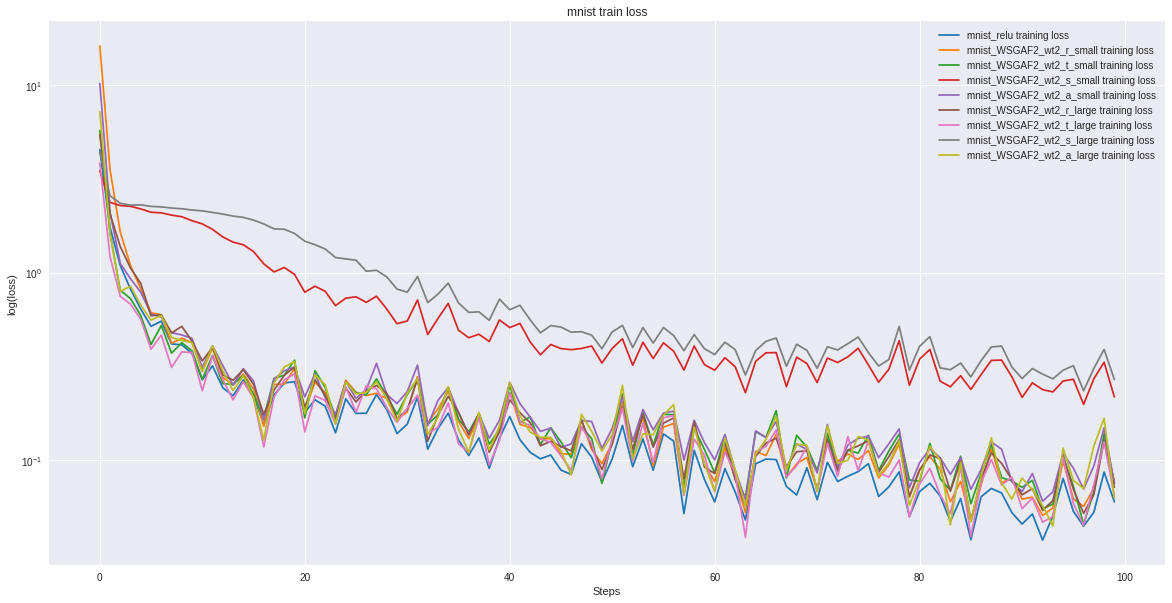

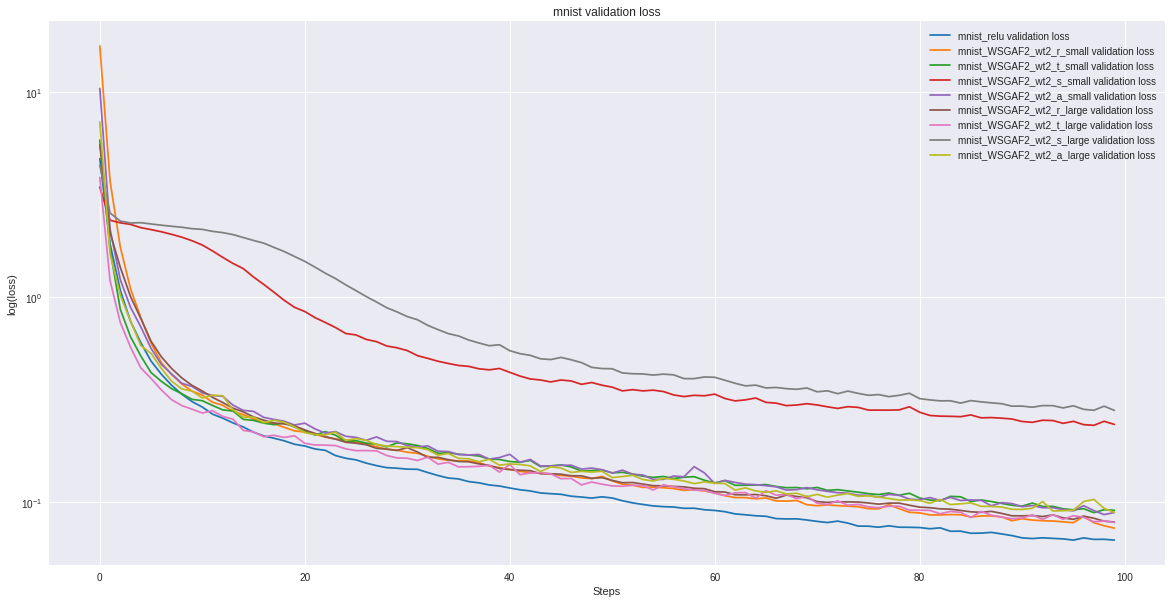

[]
step 0, fashion_mnist_relu: train_loss 9.01084, validation_loss 8.81786
step 10, fashion_mnist_relu: train_loss 1.83865, validation_loss 1.85422
step 20, fashion_mnist_relu: train_loss 1.0871, validation_loss 1.14459
step 30, fashion_mnist_relu: train_loss 0.880486, validation_loss 0.853527
step 40, fashion_mnist_relu: train_loss 0.904672, validation_loss 0.793697
step 50, fashion_mnist_relu: train_loss 0.763086, validation_loss 0.720072
step 60, fashion_mnist_relu: train_loss 0.679115, validation_loss 0.676742
step 70, fashion_mnist_relu: train_loss 0.70034, validation_loss 0.661628
step 80, fashion_mnist_relu: train_loss 0.647636, validation_loss 0.625354
step 90, fashion_mnist_relu: train_loss 0.604088, validation_loss 0.600351
step 100, fashion_mnist_relu: train_loss 0.599046, validation_loss 0.585975
step 110, fashion_mnist_relu: train_loss 0.530656, validation_loss 0.571939
step 120, fashion_mnist_relu: train_loss 0.598471, validation_loss 0.559006
step 130, fashion_mnist_relu

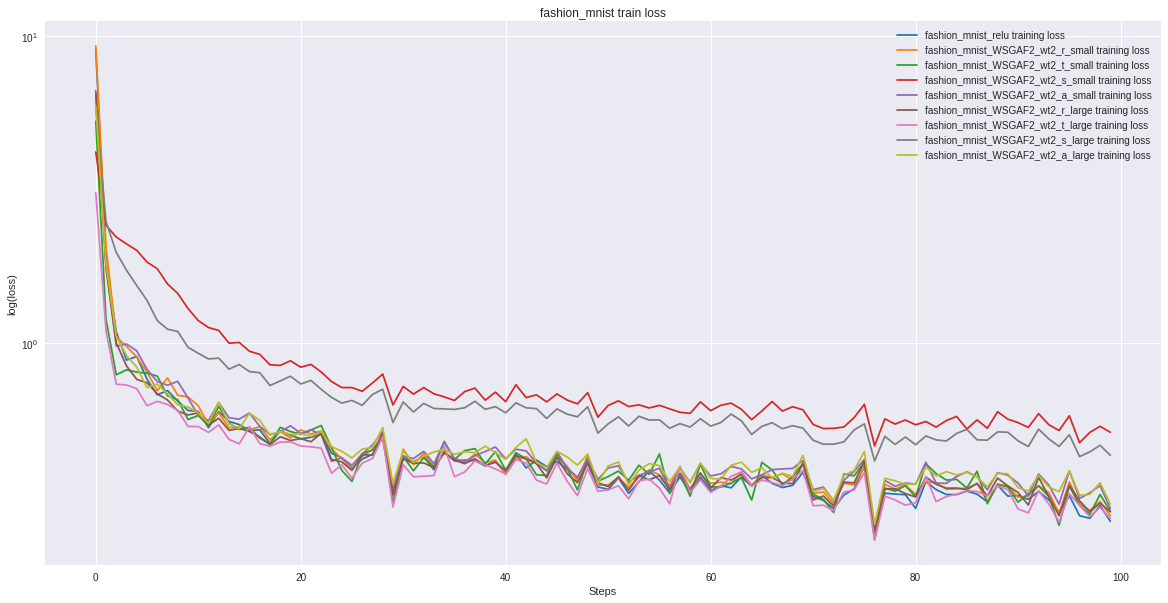

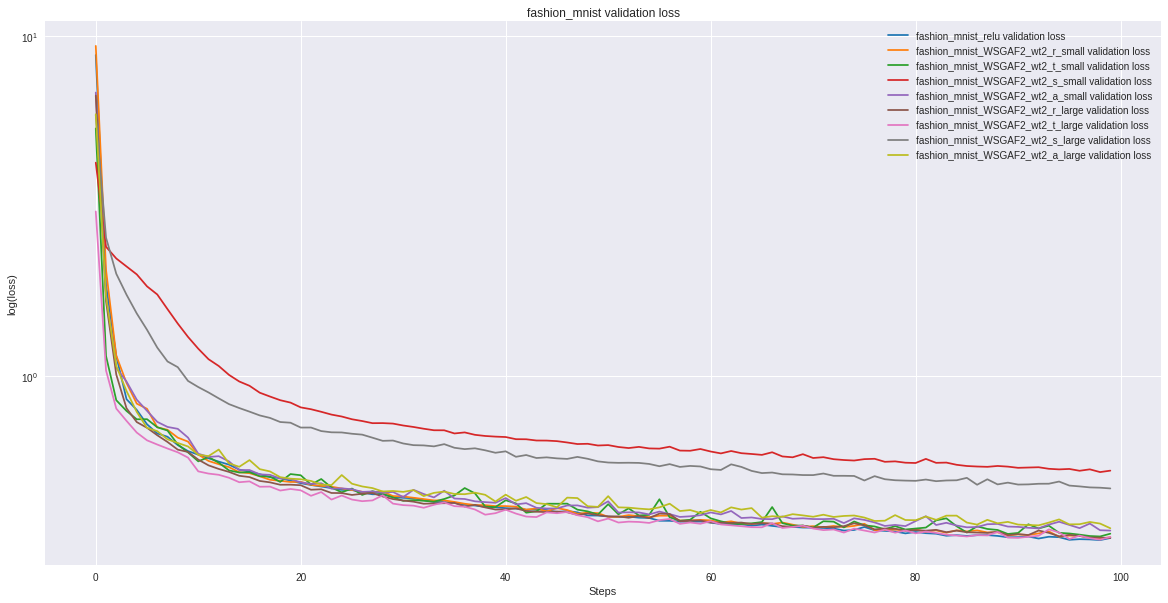

[]
step 0, cifar10_relu: train_loss 7.6293, validation_loss 8.32423
step 10, cifar10_relu: train_loss 3.54, validation_loss 3.34449
step 20, cifar10_relu: train_loss 2.56972, validation_loss 2.61447
step 30, cifar10_relu: train_loss 2.47951, validation_loss 2.28773
step 40, cifar10_relu: train_loss 2.10098, validation_loss 2.22805
step 50, cifar10_relu: train_loss 2.15846, validation_loss 2.02438
step 60, cifar10_relu: train_loss 2.17347, validation_loss 2.04629
step 70, cifar10_relu: train_loss 2.02428, validation_loss 2.0327
step 80, cifar10_relu: train_loss 1.96027, validation_loss 1.90877
step 90, cifar10_relu: train_loss 1.78157, validation_loss 1.92828
step 100, cifar10_relu: train_loss 1.79338, validation_loss 1.78299
step 110, cifar10_relu: train_loss 1.82105, validation_loss 1.82185
step 120, cifar10_relu: train_loss 1.83536, validation_loss 1.78848
step 130, cifar10_relu: train_loss 1.74687, validation_loss 1.75737
step 140, cifar10_relu: train_loss 1.59678, validation_loss 1

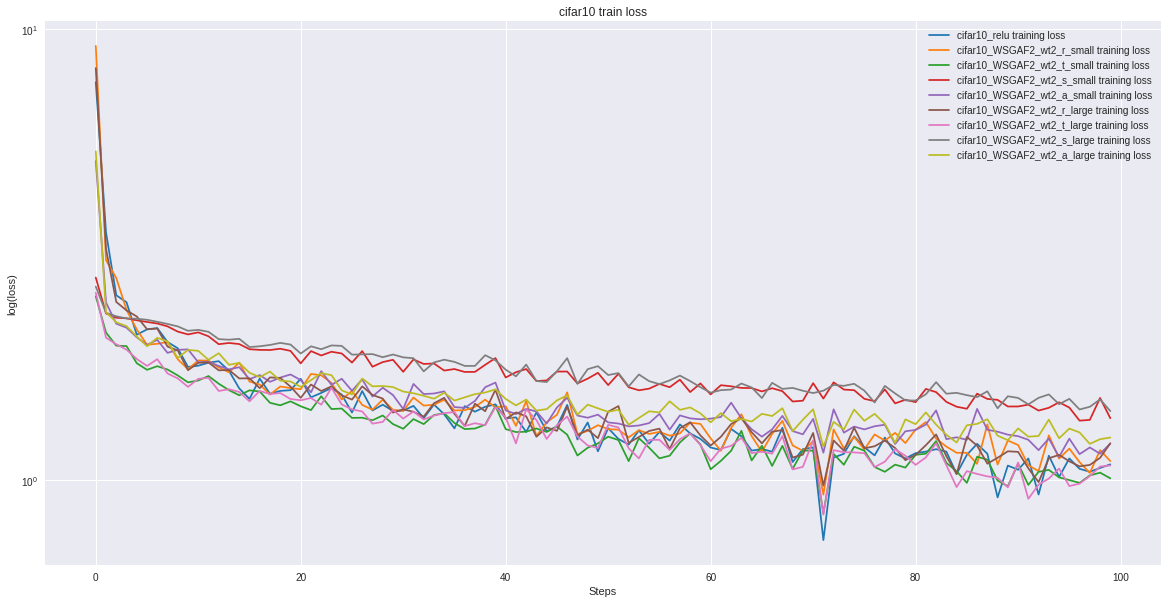

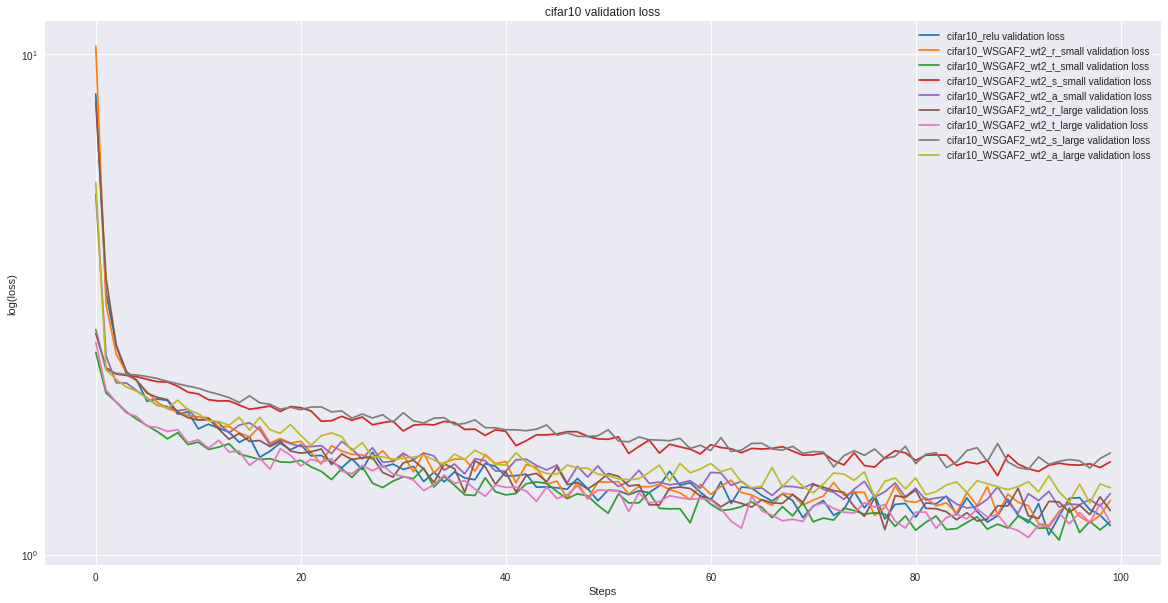

Saving accuracy figure to 'data/accuracy.png' and logs to 'data/accuracy.csv'
[[0.9811, 0.9778, 0.9736, 0.9299, 0.9726, 0.9781, 0.9776, 0.9216, 0.9744], [0.8743, 0.8758, 0.8753, 0.7899, 0.8699, 0.8724, 0.8763, 0.822, 0.869], [0.5763999998569489, 0.5796000033617019, 0.5936999946832657, 0.4794999986886978, 0.5586999982595444, 0.5755999982357025, 0.5942999988794326, 0.4654000014066696, 0.5401000007987022]]
[[0.98110002 0.8743     0.5764    ]
 [0.97780001 0.87580001 0.5796    ]
 [0.97359997 0.87529999 0.59369999]
 [0.92989999 0.7899     0.4795    ]
 [0.97259998 0.86989999 0.5587    ]
 [0.9781     0.87239999 0.5756    ]
 [0.97759998 0.87629998 0.5943    ]
 [0.92159998 0.82200003 0.4654    ]
 [0.97439998 0.86900002 0.5401    ]]


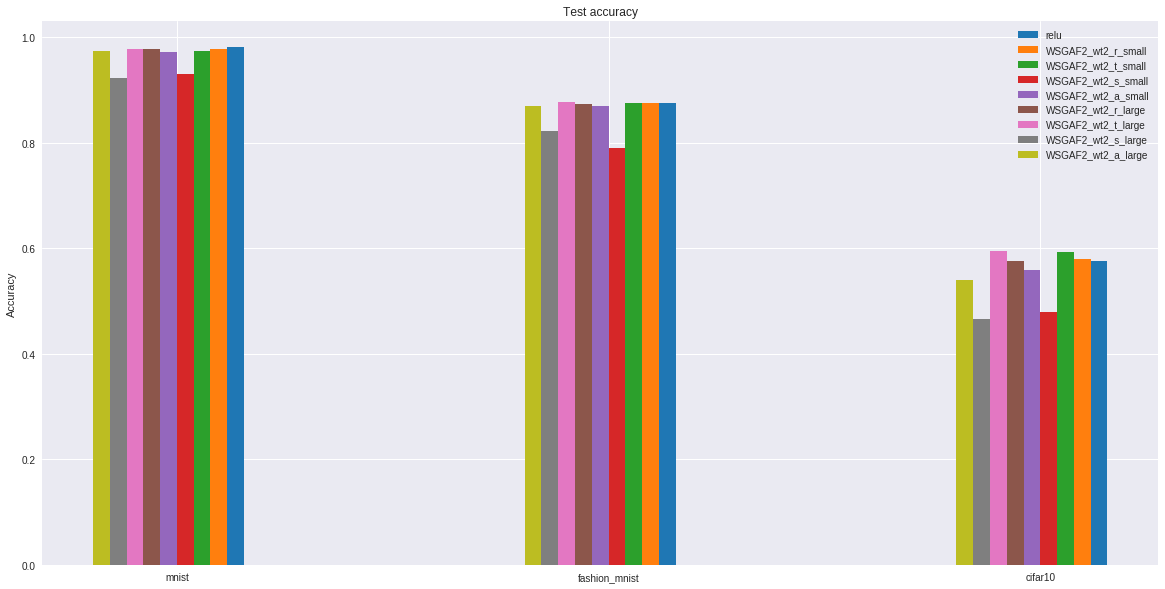

[['relu', 'WSGAF2_wt2_r_small', 'WSGAF2_wt2_t_small', 'WSGAF2_wt2_s_small', 'WSGAF2_wt2_a_small', 'WSGAF2_wt2_r_large', 'WSGAF2_wt2_t_large', 'WSGAF2_wt2_s_large', 'WSGAF2_wt2_a_large'], [0.9811, 0.9778, 0.9736, 0.9299, 0.9726, 0.9781, 0.9776, 0.9216, 0.9744], [0.8743, 0.8758, 0.8753, 0.7899, 0.8699, 0.8724, 0.8763, 0.822, 0.869], [0.5763999998569489, 0.5796000033617019, 0.5936999946832657, 0.4794999986886978, 0.5586999982595444, 0.5755999982357025, 0.5942999988794326, 0.4654000014066696, 0.5401000007987022]]
[['relu' '0.9811' '0.8743' '0.5763999998569489']
 ['WSGAF2_wt2_r_small' '0.9778' '0.8758' '0.5796000033617019']
 ['WSGAF2_wt2_t_small' '0.9736' '0.8753' '0.5936999946832657']
 ['WSGAF2_wt2_s_small' '0.9299' '0.7899' '0.4794999986886978']
 ['WSGAF2_wt2_a_small' '0.9726' '0.8699' '0.5586999982595444']
 ['WSGAF2_wt2_r_large' '0.9781' '0.8724' '0.5755999982357025']
 ['WSGAF2_wt2_t_large' '0.9776' '0.8763' '0.5942999988794326']
 ['WSGAF2_wt2_s_large' '0.9216' '0.822' '0.465400001406669

In [0]:
import os

#batch size
batch_size_mnist=512
batch_size_cifar10=512

nb_steps = 1000

output_path = "data/"
accuracy_path = output_path
accuracy_plot_path = accuracy_path + "accuracy.png"
accuracy_log_path = accuracy_path + "accuracy.csv"

# models are grouped by database. Every activation function is tested on every database
'''
# Test WSGAF different weight initializations, raw multiply with act funcs
model_groups = [{'group_name': "mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,       batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_r_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_t_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_s_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_a_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_r_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_t_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_s_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt_a_large, batch_size_mnist, mnist_database)]},
                {'group_name': "fashion_mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,       batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_r_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_t_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_s_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_a_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_r_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_t_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_s_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt_a_large, batch_size_mnist, fashion_mnist_database)]},
                {'group_name': "cifar10",
                 'models': [test_model(cifar10_model, tf.nn.relu,       batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_r_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_t_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_s_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_a_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_r_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_t_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_s_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt_a_large, batch_size_cifar10, cifar10_database)]}]
'''

'''
# Test WSGAF different weight initializations, sigmoid(weight) multiply with act funcs
model_groups = [{'group_name': "mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_r_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_t_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_s_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_a_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_r_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_t_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_s_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF_wt2_a_large, batch_size_mnist, mnist_database)]},
                {'group_name': "fashion_mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_r_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_t_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_s_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_a_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_r_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_t_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_s_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF_wt2_a_large, batch_size_mnist, fashion_mnist_database)]},
                {'group_name': "cifar10",
                 'models': [test_model(cifar10_model, tf.nn.relu,        batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_r_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_t_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_s_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_a_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_r_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_t_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_s_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF_wt2_a_large, batch_size_cifar10, cifar10_database)]}]
'''
'''
# Test WSGAF2 (single weight per layer) different weight initializations, raw multiply with act funcs
model_groups = [{'group_name': "mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_r_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_t_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_s_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_a_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_r_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_t_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_s_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt_a_large, batch_size_mnist, mnist_database)]},
                {'group_name': "fashion_mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_r_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_t_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_s_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_a_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_r_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_t_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_s_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt_a_large, batch_size_mnist, fashion_mnist_database)]},
                {'group_name': "cifar10",
                 'models': [test_model(cifar10_model, tf.nn.relu,        batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_r_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_t_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_s_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_a_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_r_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_t_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_s_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt_a_large, batch_size_cifar10, cifar10_database)]}]

'''

# Test WSGAF2 (single weight per layer) different weight initializations, sigmoid(weight) multiply with act funcs
model_groups = [{'group_name': "mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_r_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_t_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_s_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_a_small, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_r_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_t_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_s_large, batch_size_mnist, mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_a_large, batch_size_mnist, mnist_database)]},
                {'group_name': "fashion_mnist",
                 'models': [test_model(mnist_model, tf.nn.relu,        batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_r_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_t_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_s_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_a_small, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_r_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_t_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_s_large, batch_size_mnist, fashion_mnist_database),
                            test_model(mnist_model, WSGAF2_wt2_a_large, batch_size_mnist, fashion_mnist_database)]},
                {'group_name': "cifar10",
                 'models': [test_model(cifar10_model, tf.nn.relu,        batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_r_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_t_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_s_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_a_small, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_r_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_t_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_s_large, batch_size_cifar10, cifar10_database),
                            test_model(cifar10_model, WSGAF2_wt2_a_large, batch_size_cifar10, cifar10_database)]}]

# evaluate every model in every model group
for model_group in model_groups:
  for model in model_group['models']:
    evaluate_model(model, nb_steps)
  
  data_path = output_path + model_group['group_name'] + "/"
  if not os.path.isdir(data_path):
    os.makedirs(data_path)
  train_fig_path  = data_path + "training_loss.png"
  valid_fig_path  = data_path + "validation_loss.png"
  log_path  = data_path + "training_loss.csv"
  print("Saving figure to '%s' and logs to '%s'" % (train_fig_path, log_path))
  save_loss_graph(model_group, True, train_fig_path)
  save_loss_graph(model_group, False, valid_fig_path)
  save_training_logs(model_group['models'], log_path)

#

print("Saving accuracy figure to '%s' and logs to '%s'" % (accuracy_plot_path, accuracy_log_path))
save_accuracy_graph(model_groups, accuracy_plot_path)
save_accuracy_log(model_groups, accuracy_log_path)

In [0]:
!zip -r myfiles.zip data

updating: data/ (stored 0%)
updating: data/fashion_mnist/ (stored 0%)
updating: data/fashion_mnist/validation_loss.png (deflated 9%)
updating: data/fashion_mnist/training_loss.csv (deflated 58%)
updating: data/fashion_mnist/training_loss.png (deflated 6%)
updating: data/mnist/ (stored 0%)
updating: data/mnist/validation_loss.png (deflated 9%)
updating: data/mnist/training_loss.csv (deflated 57%)
updating: data/mnist/training_loss.png (deflated 5%)
updating: data/accuracy.csv (deflated 54%)
updating: data/accuracy.png (deflated 25%)
updating: data/cifar10/ (stored 0%)
updating: data/cifar10/validation_loss.png (deflated 6%)
updating: data/cifar10/training_loss.csv (deflated 57%)
updating: data/cifar10/training_loss.png (deflated 5%)


In [0]:
from google.colab import files

files.download('myfiles.zip')